In [1]:
%matplotlib widget
import math
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from mlc.util.resources import data_path

# Set the device to be used for training
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def plot_data_ax(ax, X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    ax.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y.numpy(), s=20, cmap=plt.cm.Spectral)
    ax.axis("square")
    ax.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True:
        ax.set_aspect("equal")
    ax.axis("off")

    _m, _c = 0, ".15"
    ax.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    ax.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_data(X, y, d=0, auto=False, zoom=1):
    fig, ax = plt.subplots()
    plot_data_ax(ax, X, y, d, auto, zoom)
    # fig.show()


def plot_model_ax(ax, X, y, model, detail=0.01):
    mesh = np.arange(-1.1, 1.1, detail)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.2)
    plot_data_ax(ax, X, y)


def plot_model(X, y, model, detail=0.01):
    fig, ax = plt.subplots()
    plot_model_ax(ax, X, y, model, detail)
    # fig.show()

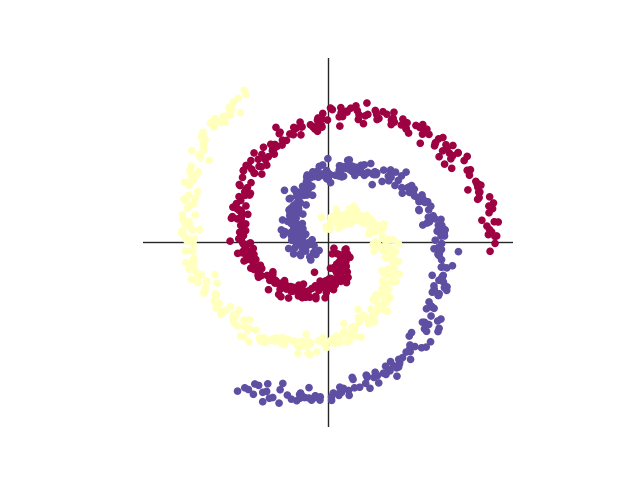

In [3]:
num_samples_per_class = 333
num_classes = 3

# Generate random data
num_samples = num_classes * num_samples_per_class


def p(t, f=0):
    x = (1 - t) * torch.vstack([torch.cos(2 * torch.pi * t + f), torch.sin(2 * torch.pi * t + f)]) + torch.randn(
        2, len(t)
    ) * 0.03
    return torch.transpose(x, 0, 1)


X, Y = [], []
a = 2 * torch.pi / num_classes
for c in range(num_classes):
    t = torch.linspace(0, 0.9, num_samples_per_class)
    X.append(p(t, c * a))
    # y is one hot encoded
    y = torch.zeros((num_samples_per_class, num_classes), dtype=torch.float32)
    y[:, c] = 1
    Y.append(y)
X = torch.vstack(X)
Y = torch.vstack(Y)
# randomize 3 times X and Y
for i in range(3):
    idx = torch.randperm(num_samples_per_class * num_classes)
    X = X[idx]
    Y = Y[idx]

# send data to device
X = X.to(device)
Y = Y.to(device)

plot_data(X, torch.argmax(Y, axis=1))

## Split into Train, Validation and Test

In [4]:
num_train_samples = math.floor(num_samples * 0.7)
num_validation_samples = math.floor(num_samples * 0.2)
num_test_samples = num_samples - num_train_samples - num_validation_samples

X_train, Y_train = X[:num_train_samples], Y[:num_train_samples]
X_validation, Y_validation = (
    X[num_train_samples : num_train_samples + num_validation_samples],
    Y[num_train_samples : num_train_samples + num_validation_samples],
)
X_test, Y_test = X[num_train_samples + num_validation_samples :], Y[num_train_samples + num_validation_samples :]

print(X_train.shape, Y_train.shape)
print(X_validation.shape, Y_validation.shape)
print(X_test.shape, Y_test.shape)

# save data as csv into data/spiral folder
path = data_path("spiral")
if path.exists() is False:
    path.mkdir(parents=True)


def save_data(X, Y, filename):
    df = pd.DataFrame(
        torch.hstack((X.cpu(), torch.argmax(Y, dim=1).reshape((-1, 1)).cpu())).numpy(), columns=["x1", "x2", "y"]
    )
    df["y"] = df["y"].astype(int)
    df.to_csv(filename, index=False)


save_data(X_train, Y_train, data_path("spiral") / "train.csv")
save_data(X_validation, Y_validation, data_path("spiral") / "validation.csv")
save_data(X_test, Y_test, data_path("spiral") / "test.csv")

torch.Size([699, 2]) torch.Size([699, 3])
torch.Size([199, 2]) torch.Size([199, 3])
torch.Size([101, 2]) torch.Size([101, 3])


Epoch 99, loss [t/v]: 0.264/0.299: 100%|██████████| 100/100 [00:06<00:00, 14.58it/s]


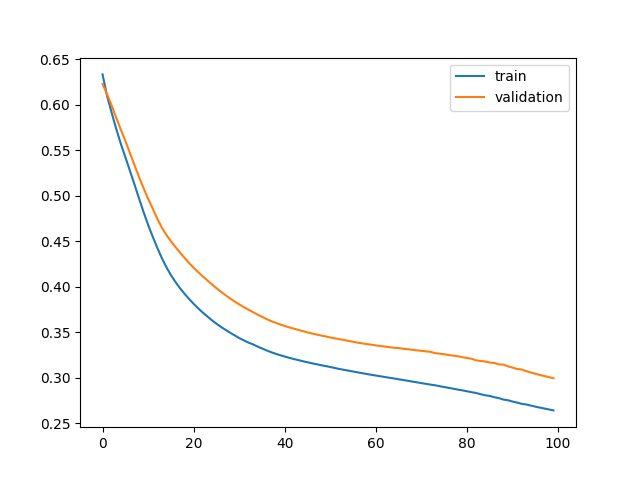

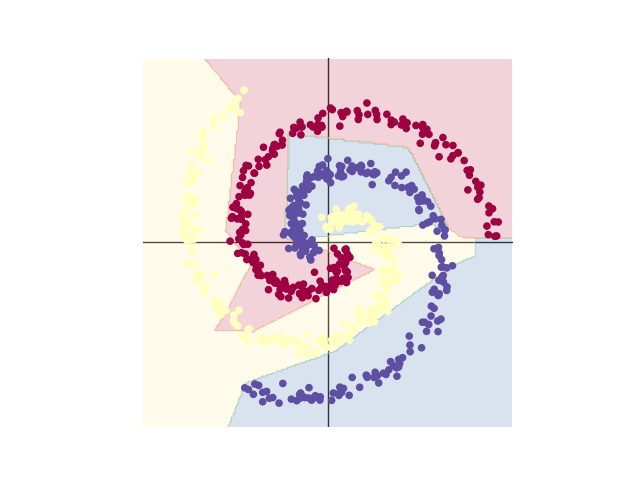

In [5]:
epochs = 100
batch_size = 32
learning_rate = 0.01


model = torch.nn.Sequential(
    torch.nn.Linear(2, 10), torch.nn.ReLU(inplace=True), torch.nn.Linear(10, num_classes), torch.nn.Softmax(dim=1)
)
model.to(device)

# https://pytorch.org/docs/stable/nn.html#loss-functions
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
validation_losses = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    model.train()
    loss_val = 0
    for i in range(0, num_train_samples, batch_size):
        X_batch = X_train[i : i + batch_size]
        Y_batch = Y_train[i : i + batch_size]

        optimizer.zero_grad()
        Y_pred = model(X_batch)
        loss = loss_fn(Y_pred, Y_batch)
        loss.backward()
        optimizer.step()

        loss_val += loss.item() * len(X_batch)

    train_losses.append(loss_val / num_train_samples)

    model.eval()
    with torch.no_grad():
        Y_pred = model(X_validation)
        loss = loss_fn(Y_pred, Y_validation)

        validation_losses.append(loss.item())

    pbar.set_description(f"Epoch {epoch}, loss [t/v]: {train_losses[-1]:0.3f}/{validation_losses[-1]:0.3f}")

    # print(f"Epoch {epoch}, loss: {loss.item()}")

plt.figure()
plt.plot(train_losses, label="train")
plt.plot(validation_losses, label="validation")
plt.legend()
plt.show()

plot_model(X_train, torch.argmax(Y_train, axis=1), model.to("cpu"))

In [6]:
model.eval()
print(X_test.device)
with torch.no_grad():
    model.to(device)
    Y_pred = model(X_test)
    loss = loss_fn(Y_pred, Y_test)
    print(f"Test loss: {loss.item()}")

    Y_pred_class = torch.argmax(Y_pred, dim=1)
    Y_test_class = torch.argmax(Y_test, dim=1)
    accuracy = torch.sum(Y_pred_class == Y_test_class).item() / num_test_samples
    print(f"Test accuracy: {accuracy}")

cuda:0
Test loss: 0.306761234998703
Test accuracy: 0.7821782178217822


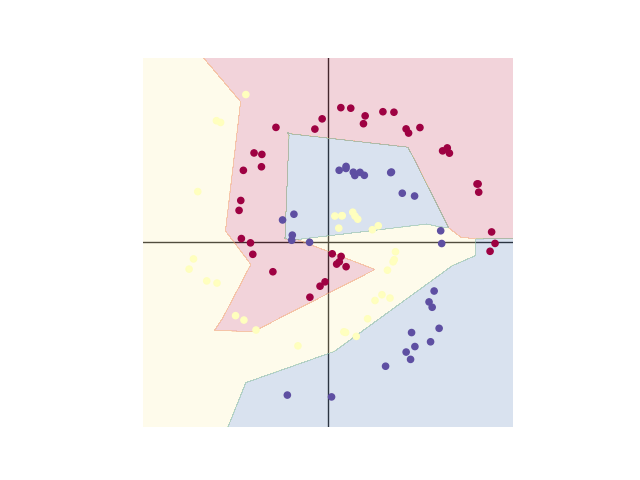

In [8]:
plot_model(X_test, torch.argmax(Y_test, dim=1), model.to("cpu"), detail=0.001)
